In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "5"

isola-h100-1.csail.mit.edu
/vision-nfs/isola/env/akumar01/synthetic-mdps/src
/vision-nfs/isola/env/akumar01/.virtualenvs/smdps/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [67]:
import compile_experiment
from mdps import create_smdp

In [5]:
dir_data = "/vision-nfs/isola/env/akumar01/synthetic-mdps-data/"

In [267]:
# envs_mujoco = ["Reacher", "InvertedPendulum", "InvertedDoublePendulum", "HalfCheetah", "Hopper", "Walker2d", "Ant", "Humanoid", "HumanoidStandup"]
# envs_mujoco = ["Reacher", "InvertedPendulum", "InvertedDoublePendulum", "HalfCheetah", "Hopper", "Walker2d", "Ant"]
envs_mujoco = ["Reacher", "InvertedPendulum", "HalfCheetah", "Hopper"]
envs_synthetic = compile_experiment.envs_synthetic

In [268]:
data = []
for env in envs_mujoco:
    with open(f"{dir_data}/icl_test/{env}/scratch/metrics_before.pkl", "rb") as f:
        a = jax.tree.map(lambda x: np.array(x), pickle.load(f))
    data.append(['scratch', env, a['loss'].mean(), a['rets'].mean()])
    # with open(f"{dir_data}/icl_test/{env}/random/metrics_before.pkl", "rb") as f:
    #     a = jax.tree.map(lambda x: np.array(x), pickle.load(f))
    # data.append(['random', env, a['loss'].mean(), a['rets'].mean()])
    
    with open(f"{dir_data}/icl_test/{env}/{env}_oracle/metrics_before.pkl", "rb") as f:
        a = jax.tree.map(lambda x: np.array(x), pickle.load(f))
    data.append(['oracle', env, a['loss'].mean(), a['rets'].mean()])

    with open(f"{dir_data}/icl_test/{env}/{env}_oracle_aug/metrics_before.pkl", "rb") as f:
        a = jax.tree.map(lambda x: np.array(x), pickle.load(f))
    data.append(['oracle_aug', env, a['loss'].mean(), a['rets'].mean()])

    with open(f"{dir_data}/icl_test/{env}/{env}_gato_aug/metrics_before.pkl", "rb") as f:
        a = jax.tree.map(lambda x: np.array(x), pickle.load(f))
    data.append(['gato_aug', env, a['loss'].mean(), a['rets'].mean()])

    for pre in tqdm(envs_synthetic):
        with open(f"{dir_data}/icl_test/{env}/{pre}_oracle_aug/metrics_before.pkl", "rb") as f:
            a = jax.tree.map(lambda x: np.array(x), pickle.load(f))
        data.append([pre, env, a['loss'].mean(), a['rets'].mean()])   
df = pd.DataFrame(data, columns=['Pretraining', 'TestEnv', 'Loss','Return'])

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

In [269]:
a = df.pivot(index='Pretraining', columns='TestEnv', values='Return')
upper, lower = a.loc['oracle'], a.loc['scratch']
df['upper'] = upper.loc[df['TestEnv']].to_numpy()
df['lower'] = lower.loc[df['TestEnv']].to_numpy()
df['NormalizedReturn'] = (df['Return']-df['lower'])/(df['upper']-df['lower'])

In [270]:
agg_df = df.groupby('Pretraining').agg({'NormalizedReturn': 'mean','Loss': 'mean'}).reset_index()
agg_df['TestEnv'] = 'Aggregate'
df = pd.concat([df, agg_df], ignore_index=True)

In [271]:
def get_family_name(env):
    if 'name' in env:
        args = dict([part.split('=') for part in env.split(';')])
        return args['name']
    else:
        return env
df['Family'] = [get_family_name(env) for env in df['Pretraining']]

In [272]:
df['Family'] = pd.Categorical(df['Family'], categories=['scratch', 'oracle', 'oracle_aug', 'gato_aug', 'mchain', 
                                                        'bandit', 'dsmdp', 'mdsmdp', 'csmdp', 'ecsmdp', 'ucsmdp', 'hsmdp'], ordered=True)
df['TestEnv'] = pd.Categorical(df['TestEnv'], categories=envs_mujoco+['Aggregate'], ordered=True)
df = df.sort_values(['Family', 'TestEnv'])
df = df.reset_index(drop=True)

In [273]:
print(df[(df.TestEnv=='Aggregate')& (df.Family=='ucsmdp')]['NormalizedReturn'].max())

0.28231266095897634


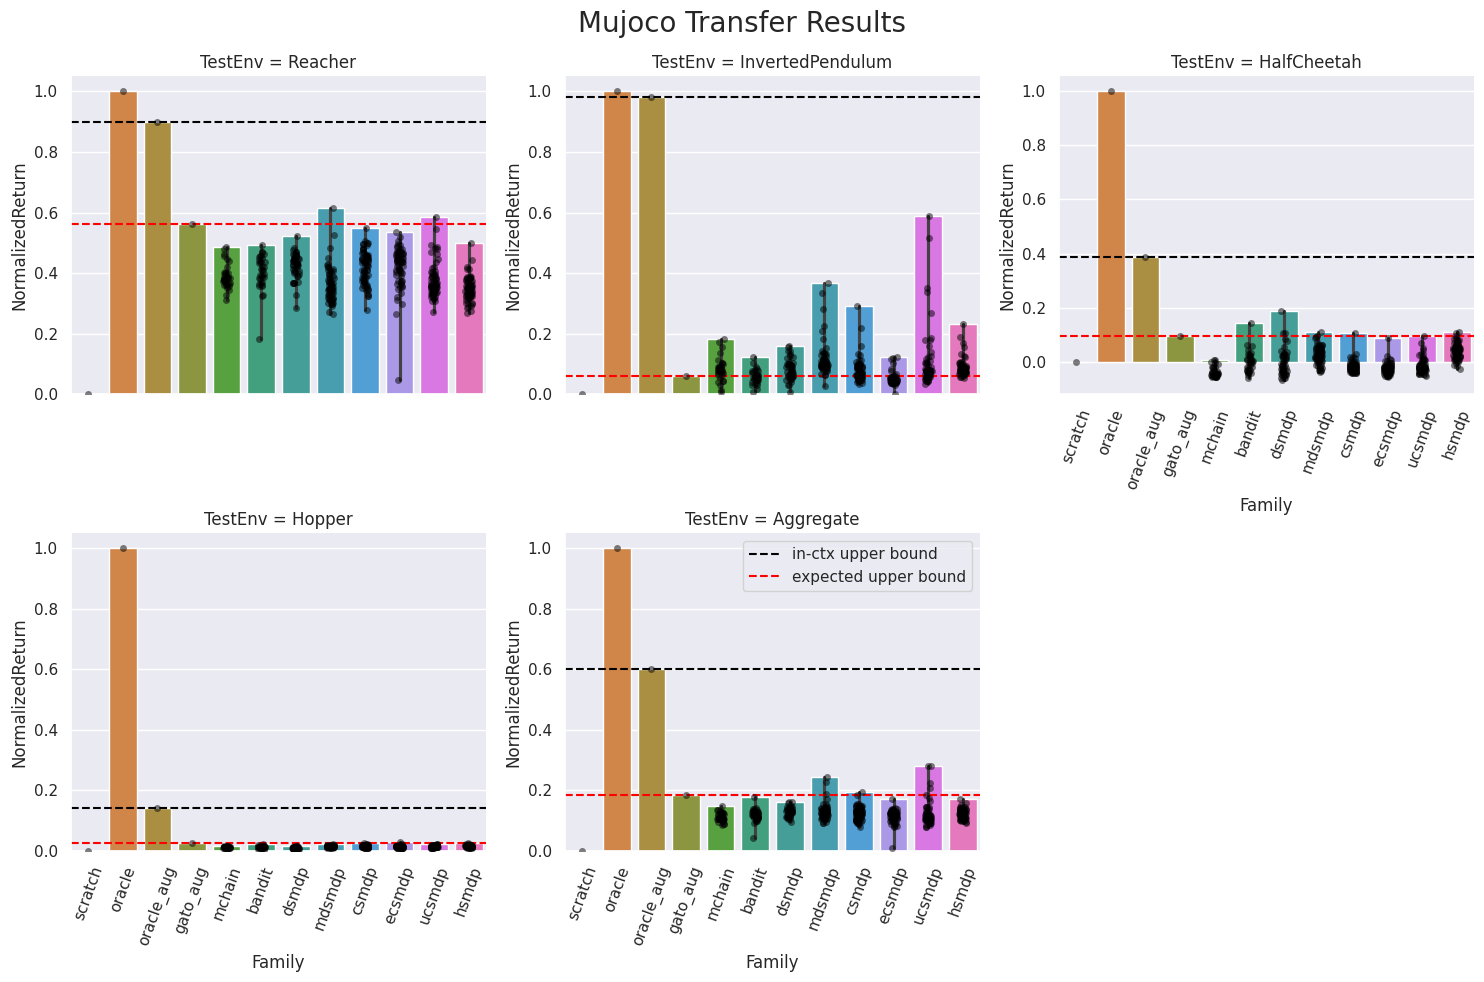

In [274]:
metric = 'NormalizedReturn'
# metric = 'Loss'

g = sns.catplot(data=df, x='Family', y=metric, kind="bar", hue="Family", col='TestEnv', col_wrap=3,
                sharey=False, estimator='min' if metric=='Loss' else 'max', errorbar=('pi', 100))

for ax, (name, group_data) in zip(g.axes.flat, df.groupby('TestEnv', observed=True)):
    sns.stripplot(data=group_data, x='Family', y=metric, ax=ax, color='black', alpha=0.5)
    ax.tick_params(axis='x', rotation=70)
    # ax.axhline(group_data[group_data.Pretraining=='scratch'][metric].item(), c='green', label='lower bound')
    # ax.axhline(group_data[group_data.Pretraining=='oracle'][metric].item(), c='black', label='upper bound')
    ax.axhline(group_data[group_data.Pretraining=='oracle_aug'][metric].item(), c='black', linestyle='dashed', label='in-ctx upper bound')
    ax.axhline(group_data[group_data.Pretraining=='gato_aug'][metric].item(), c='red', linestyle='dashed', label='expected upper bound')
plt.legend()
plt.suptitle('Mujoco Transfer Results', fontsize=20)
plt.tight_layout()
# plt.ylim(0, 0.3)

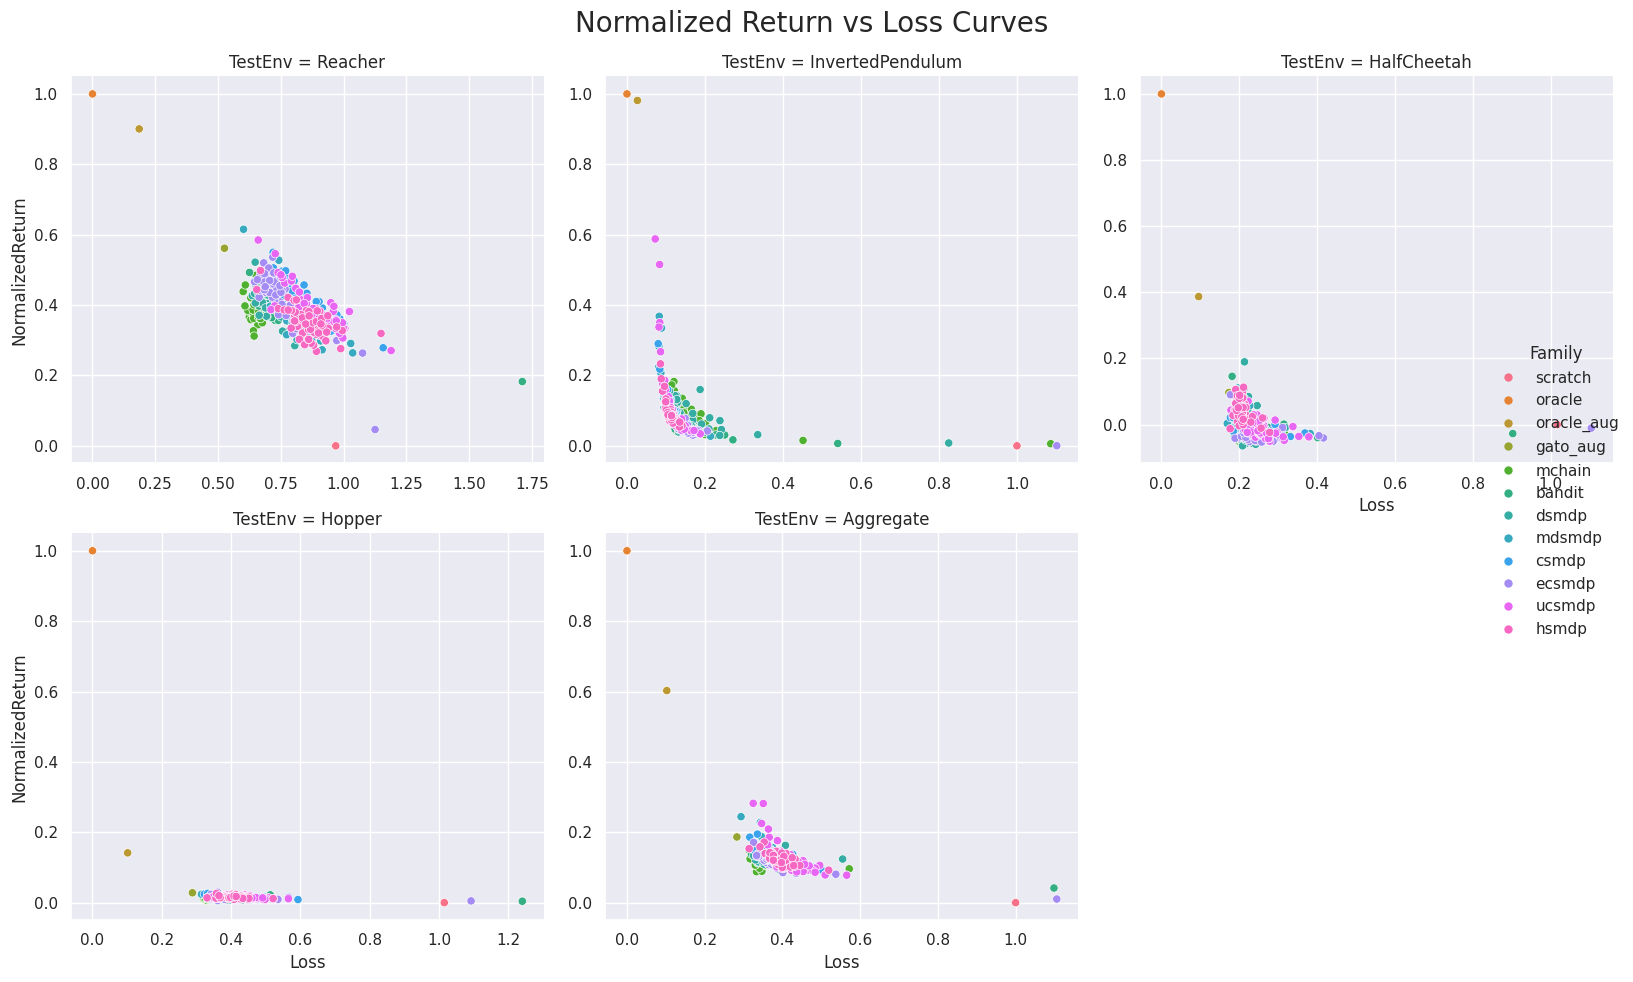

In [276]:
g = sns.relplot(df, x='Loss', y='NormalizedReturn', col='TestEnv', hue='Family', col_wrap=3, facet_kws={'sharey': False, 'sharex': False, })
plt.suptitle("Normalized Return vs Loss Curves", fontsize=20)
plt.tight_layout()

In [277]:
from collections import defaultdict

In [278]:
axes = list(create_smdp.axis2name.keys())

In [279]:
axis2vals = []
for env in df['Pretraining']:
    if 'name' in env:
        args = defaultdict(lambda: np.nan, [part.split('=') for part in env.split(';')])
        axis2val = {axis: args[axis] for axis in axes}
    else:
        axis2val = {axis: np.nan for axis in axes}
    axis2vals.append(axis2val)

In [280]:
df = pd.concat([df, pd.DataFrame(axis2vals)], axis=1) 

  0%|          | 0/17 [00:00<?, ?it/s]

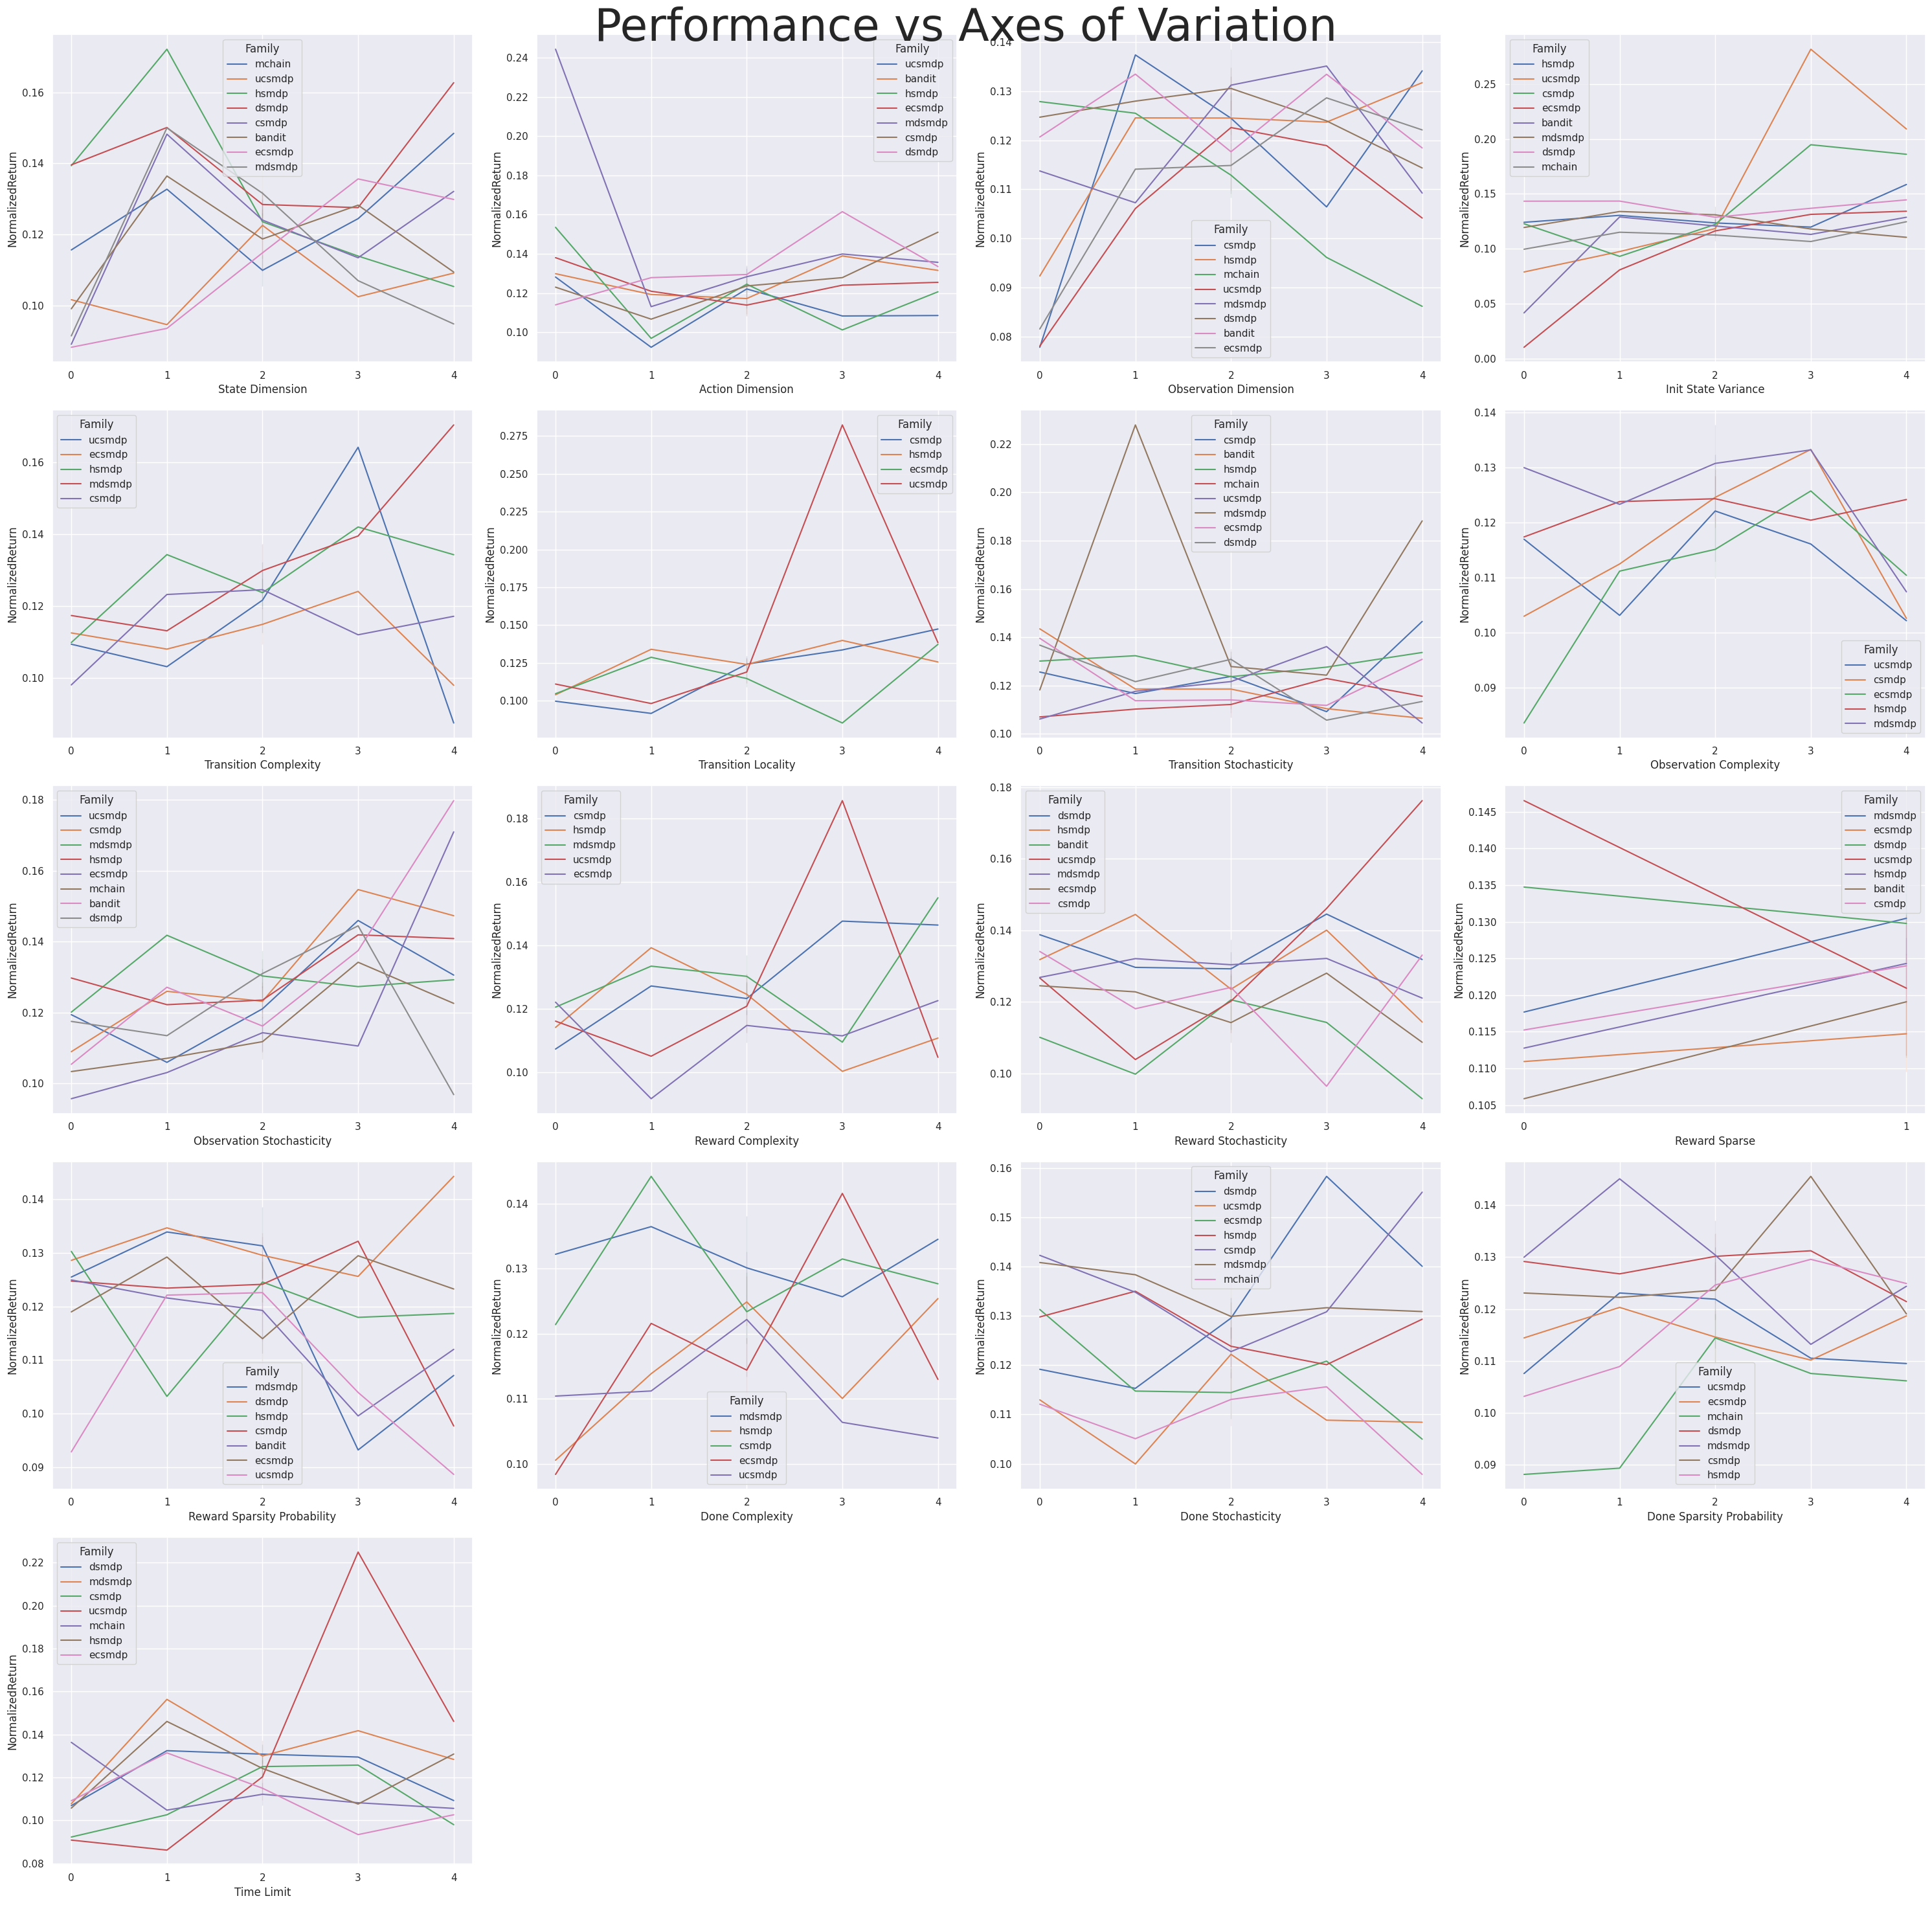

In [288]:
metric = 'NormalizedReturn'
# metric = 'Loss'

plt.figure(figsize=(30, 30))
for i_plt, axis in enumerate(tqdm(axes)):
    plt.subplot(5, 4, i_plt+1)
    dfi = df[df.TestEnv=='Aggregate']
    dfi = dfi.sort_values(axis)
    dfi = dfi[~dfi[axis].isna()]
    dfi['Family'] = pd.Categorical(dfi['Family'], categories=list(dfi['Family'].unique()), ordered=True)
    sns.lineplot(data=dfi, x=axis, y=metric, hue='Family')
    plt.xlabel(create_smdp.axis2name[axis])

plt.suptitle("Performance vs Axes of Variation", fontsize=50)
plt.tight_layout()
plt.show()

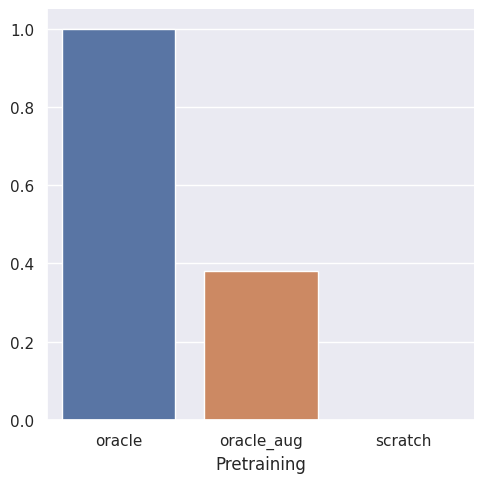

In [27]:
a = df.pivot(index='Pretraining', columns='TestEnv', values='NormalizedReturn').mean(axis=1)
# sns.catplot(data=a, kind="bar", hue=a.index)
sns.catplot(x=a.index, y=a.values, kind='bar', hue=a.index)

In [111]:
with open("/vision-nfs/isola/env/akumar01/synthetic-mdps-data/temp/csmdp/rets_train.pkl", "rb") as f:
    a = pickle.load(f)
df = pd.DataFrame(a).T

In [112]:
df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-6.502972,15.040921,-1.880490,-9.936020,2.846055,1.474305,3.573270,1.312932,-13.699976,8.814011,...,-4.191244,0.344719,-10.245337,35.459705,-2.255260,-8.198369,77.537796,5.584847,-22.056063,70.334641
1,-3.992263,26.035004,2.630036,-11.251588,4.229982,1.189525,10.023714,0.136752,-11.646237,9.963139,...,-7.551313,0.389007,-12.716383,48.086773,-4.616920,-15.531517,92.859558,7.318928,-21.613735,82.029121
2,-6.189260,17.020317,-0.625783,-10.230042,4.419254,3.168363,8.088915,-0.134355,-11.702636,10.615231,...,-6.873537,0.545502,-8.308290,48.787537,-3.566428,-10.711180,96.093834,10.690768,-26.366573,81.677292
3,-8.828253,19.458174,0.234620,-8.547576,5.430658,3.050451,2.987031,0.681745,-10.403436,10.144901,...,-3.555533,0.376337,-9.536273,69.231667,-3.569190,-8.055202,99.618103,10.937193,-22.958218,84.186447
4,-8.217764,27.474632,-0.153844,-11.256466,5.285131,3.414316,8.312411,-0.424860,-8.895960,10.605064,...,-5.028807,0.612122,-8.554779,90.411194,-4.211885,-8.697543,105.634354,13.187302,-24.194473,81.865059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-2.627203,56.002972,8.199113,-5.207355,9.876444,5.425715,15.731141,7.538620,-6.063640,14.813324,...,-0.601495,3.779912,5.387104,132.391571,3.602387,3.738402,147.881729,39.342522,-7.416295,89.063278
96,-1.993032,47.643997,5.649266,-5.333108,10.067081,7.416261,14.308775,4.846914,-6.823302,13.545530,...,0.263327,1.481369,4.454588,129.165863,1.471217,6.464692,129.178818,37.814247,-5.888225,89.668549
97,-1.886097,44.880043,9.112751,-6.162228,10.139027,12.523617,15.574270,8.375421,-5.696499,13.687423,...,-0.673859,2.369239,3.502831,121.209183,2.174904,6.835181,143.710541,40.594009,-10.056053,87.545578
98,-4.158720,50.332088,7.465018,-6.269266,11.993006,11.326046,11.868765,5.386895,-3.343064,12.096193,...,-2.112022,4.172851,3.637352,121.895752,2.035174,4.380250,133.170593,41.373772,-10.275293,90.104156


In [114]:
df = df.reset_index().melt(id_vars=['index'], var_name='EnvSeed', value_name='Return')
df = df.rename(columns={'index': 'time'})

In [115]:
df

,time,EnvSeed,Return
0,0,0,-6.502972
1,1,0,-3.992263
2,2,0,-6.189260
3,3,0,-8.828253
4,4,0,-8.217764
...,...,...,...
102395,95,1023,89.063278
102396,96,1023,89.668549
102397,97,1023,87.545578
102398,98,1023,90.104156


<Axes: xlabel='time', ylabel='Return'>

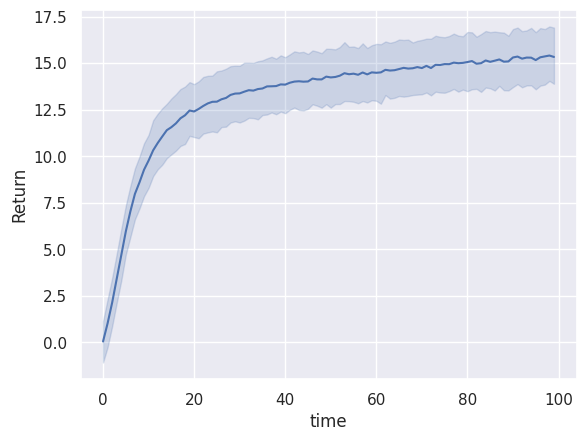

In [116]:
sns.lineplot(df, x='time', y='Return')